In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
mnist # one row per sample, one col per feature

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

In [4]:
X = mnist['data']
y = mnist['target']
print(X.shape) # 28x28 = 784
print(y.shape)

(70000, 784)
(70000,)


In [10]:
# split train, test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
import numpy as np

# shuffle
shuffle_idx = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

(-0.5, 27.5, 27.5, -0.5)

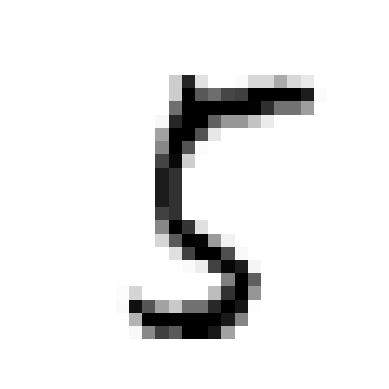

In [40]:
import matplotlib.pyplot as plt

# plot sample image

plt.imshow(X_train[15].reshape(28, 28), cmap=plt.get_cmap('binary'), interpolation='nearest')
plt.axis('off')

# Training binary classifier: Stochastic Gradient Descent

In [32]:
from sklearn.linear_model import SGDClassifier

sgd_bin = SGDClassifier(random_state=42) # depends on random, as it is stochastic
sgd_bin.fit(X_train, (y_train == '5')) # detect all 1

SGDClassifier(random_state=42)

In [41]:
sgd_bin.predict([X_train[15]])

array([ True])

In [44]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_bin, X_train, (y_train == '5'), cv=3, scoring="accuracy")

array([0.9456 , 0.94225, 0.9653 ])

In [50]:
# stratified sampling via own implementation of cross validation

from sklearn.model_selection import StratifiedKFold # stratified sampling based on label
from sklearn.base import clone # creates unfitted estimator with same hyperparams
from sklearn.metrics import accuracy_score

skfolds = StratifiedKFold(n_splits=3)

y_train_5 = (y_train=='5')

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_sgd = clone(sgd_bin)
    clone_sgd.fit(X_train[train_idx], y_train_5[train_idx])
    y_pred = clone_sgd.predict(X_train[test_idx])
    acc = accuracy_score(y_pred=y_pred, y_true=y_train_5[test_idx])
    print(acc)

0.9456
0.94225
0.9653


## Metrics

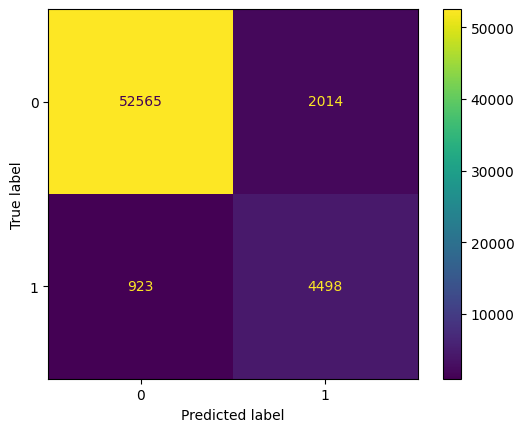

In [53]:
from sklearn.model_selection import cross_val_predict # cross validation and "clean" prediction on each test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_cross_preds = cross_val_predict(sgd_bin, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_pred=y_cross_preds, y_true=y_train_5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [57]:
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1]) # TP / (TP + FP)
precision # 100% if we only predict one sample as TP

0.6907248157248157

In [58]:
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) # recall, sensitivity, true positive rate
recall

0.829736211031175

In [63]:
# f1: harmonic mean of recall and precision -> gives more weight to low values
f1 = 2/ ((1/recall) + (1/precision))
f1 = 2* (precision*recall)/(precision + recall)
f1

0.7538758065867761

In [61]:
from sklearn.metrics import f1_score

f1_score(y_cross_preds, y_train_5)

0.7538758065867761

### Precision-Recall-Tradeoff

In [64]:
y_scores = sgd_bin.decision_function([X_train[0]])
y_scores # get score for SGD if > 0 -> True else False

array([-12723.21737799])

In [65]:
y_scores = cross_val_predict(sgd_bin, X_train, y_train_5, cv=3,
                             method="decision_function") # return scoring instead of predicted label

In [66]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

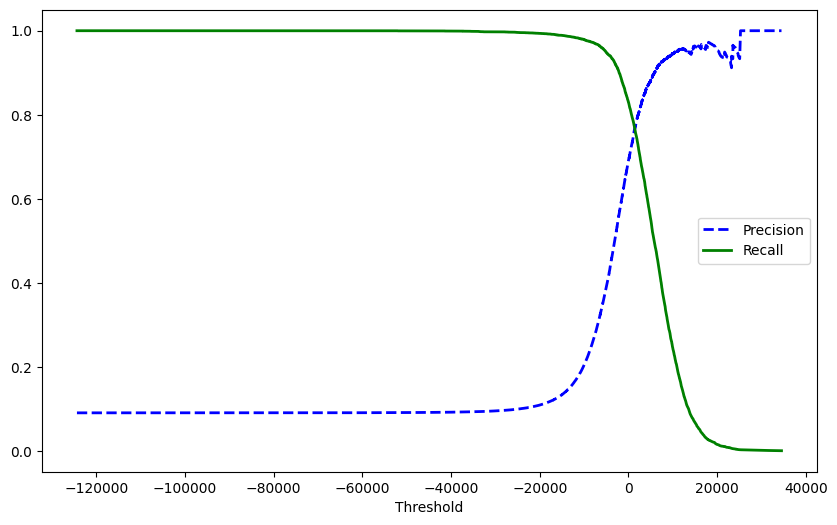

In [73]:
plt.figure(figsize=(10, 6))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold")
plt.legend(loc="center right")
# note that precision may go down when threshold increases

In [74]:
# find threshold for precision > 90%
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

5841.399026604764

In [77]:
from sklearn.metrics import precision_score, recall_score

y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9

In [79]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.49640287769784175

### ROC Curve
Plotting of TPR vs. FPR.


Tradeoff between TPR and FPR. The more true positives, the more false positives.

In [80]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Text(0, 0.5, 'True Positive Rate (Recall)')

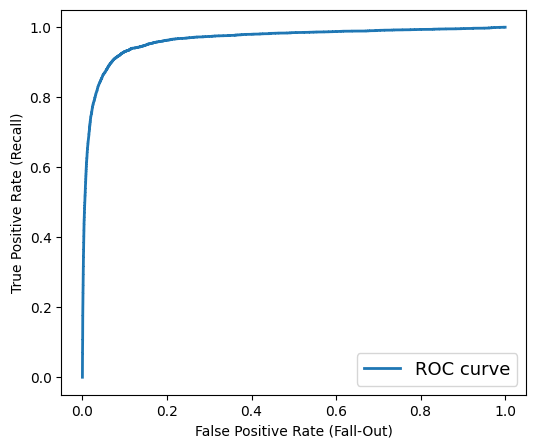

In [86]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.legend(loc="lower right", fontsize=13)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')

In [87]:
# receiver-operator curve: 1 -> perfect classifier, 0.5 -> random classifier
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9646460085228734

In [88]:
# compare SGD to Random Forrest Classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba") # use probabilites as scores -> for ROC curves

In [89]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5, y_scores_forest)

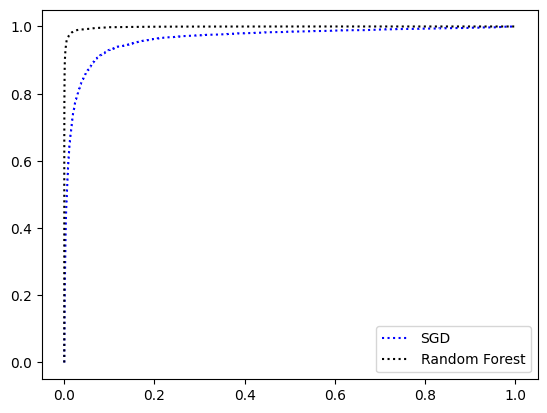

In [92]:
plt.plot(fpr, tpr, "b:", label='SGD')
plt.plot(fpr_forest, tpr_forest, "k:", label="Random Forest")
plt.legend(loc="lower right")

In [93]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984010711171961